# VAE (Variational Autoencoders) on MNIST Dataset

<img src="../images/vae.png" alt="Variational Autoencoder" width="600"/>


In [1]:
!pip install torchvision

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


## 2. Define the VAE Architecture

The VAE consists of an encoder and a decoder. The encoder compresses the input into a latent space, and the decoder reconstructs the input from this latent representation.


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.enc1 = nn.Linear(28*28, 512)
        self.enc2 = nn.Linear(512, 256)
        self.enc_mu = nn.Linear(256, latent_dim)
        self.enc_logvar = nn.Linear(256, latent_dim)
        # Decoder
        self.dec1 = nn.Linear(latent_dim, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, 28*28)

    def encode(self, x):
        x = torch.relu(self.enc1(x))
        x = torch.relu(self.enc2(x))
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = torch.relu(self.dec1(z))
        z = torch.relu(self.dec2(z))
        z = torch.sigmoid(self.dec3(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


## 3. Define the Loss Function

The VAE loss comprises two components: reconstruction loss and KL divergence.


In [4]:
def loss_function(reconstructed_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## 4. Load the MNIST Dataset**

Use `torchvision` to load and preprocess the MNIST dataset.

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:16<00:00, 592205.21it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 276228.11it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1175867.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1546058.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 5. Initialize the Model, Optimizer, and Device**

Set up the VAE model, optimizer, and specify the device for computation.


In [6]:

latent_dim = 20
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


VAE(
  (enc1): Linear(in_features=784, out_features=512, bias=True)
  (enc2): Linear(in_features=512, out_features=256, bias=True)
  (enc_mu): Linear(in_features=256, out_features=20, bias=True)
  (enc_logvar): Linear(in_features=256, out_features=20, bias=True)
  (dec1): Linear(in_features=20, out_features=256, bias=True)
  (dec2): Linear(in_features=256, out_features=512, bias=True)
  (dec3): Linear(in_features=512, out_features=784, bias=True)
)

## 6. Train the VAE

Train the VAE over multiple epochs, computing the loss and updating the model parameters.


In [7]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = loss_function(reconstructed_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch 1, Loss: 174.6050
Epoch 2, Loss: 127.5351
Epoch 3, Loss: 117.1639
Epoch 4, Loss: 112.6516
Epoch 5, Loss: 110.1384
Epoch 6, Loss: 108.4947
Epoch 7, Loss: 107.1692
Epoch 8, Loss: 106.1318
Epoch 9, Loss: 105.2784
Epoch 10, Loss: 104.5170


## 7. Generate New Images

After training, generate new images by sampling from the latent space.


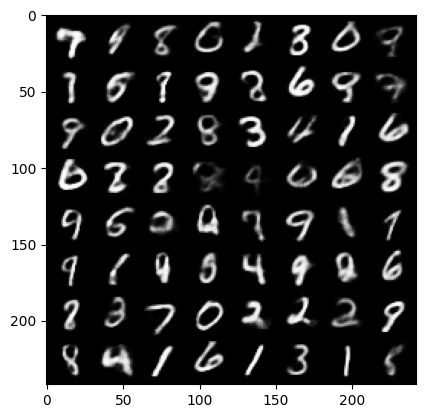

In [9]:
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 1, 28, 28)
    grid_img = torchvision.utils.make_grid(sample, nrow=8)
    plt.imshow(grid_img.permute(1, 2, 0), cmap='gray')
    plt.show()